# Microsatellite Genomic Subcompartment Analysis

In [5]:
from pathlib import Path
import os
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
from tqdm import tqdm
from collections import Counter
from collections import defaultdict
import numpy as np

warnings.filterwarnings('ignore')
load_dotenv('env.txt')
target = Path(os.getenv("tandem_path"))
coverage = Path(os.getenv("coverage"))

In [4]:
domains = ["Archaea", "Eukaryota", "Bacteria", "Viruses"]
domain_colors = {
                'Viruses': '#6bb5c7',
                'Eukaryota': '#ffb2b2',
                'Archaea': '#7b7bed',
                'Bacteria': '#a3c4a3'
                }

kingdom_color_palette = {
                          "Viruses": "#6bb5c7",
                         "Bacteria": "#0fbf2d",
                         "Archaea": "#b2b2ff",
                         "Fungi": "#4d325e",
                         "Plantae": "#b50996",
                        "Eubacteria": "#0fbf2d",
                        "Animalia": "#9bba2d",
                        "Protista": "#c78f5b",
                          "Archaeabacteria": "#7b7bed",
                } 


figures = Path(f"{target}/figures")
assembly_df = pd.read_csv(f"{target}/assembly_summary_newdb.txt.gz", delimiter="\t",)
assembly_df

,#assembly_accession,genome_size,total_gene_count,protein_coding_gene_count,non_coding_gene_count,gc_percent,species_taxid,organism_name,phylum,kingdom,superkingdom
0,GCF_000762265.1,2449987,2445,2386,55,41.5,2162,Methanobacterium formicicum,Euryarchaeota,Archaeabacteria,Archaea
1,GCF_001458655.1,2494510,2462,2404,55,41.0,2162,Methanobacterium formicicum,Euryarchaeota,Archaeabacteria,Archaea
2,GCF_002813085.1,1805545,1782,1715,43,31.0,2173,Methanobrevibacter smithii,Euryarchaeota,Archaeabacteria,Archaea
3,GCF_022846155.1,1791153,1738,1680,44,31.0,2173,Methanobrevibacter smithii,Euryarchaeota,Archaeabacteria,Archaea
4,GCF_022846175.1,1791155,1739,1681,44,31.0,2173,Methanobrevibacter smithii,Euryarchaeota,Archaeabacteria,Archaea
...,...,...,...,...,...,...,...,...,...,...,...
118097,GCA_037114785.1,42928,na,na,na,35.0,3127874,Enterococcus phage vB_Efa_ZAT1,NaN,NaN,Viruses
118098,GCA_037114795.1,18740,na,na,na,37.5,3127946,Bacillus phage vB_Bsu_hmny1,NaN,NaN,Viruses
118099,GCA_037114805.1,18762,na,na,na,37.5,3127947,Bacillus phage vB_Bsu_hmny2,NaN,NaN,Viruses
118100,GCA_037114815.1,43533,na,na,na,43.5,3127948,Vibrio phage Va-ZX-1,NaN,NaN,Viruses


In [6]:
df = pd.read_csv(f"{coverage}/overlap_compartments.coverage", delimiter="\t", )
df.head()  

,#assembly_accession,compartment,hits,basePairsCovering,compartmentSize,coverage,sru,mergedCompartment
0,GCA_000007325.1,CDS,3,32,1932314,16.560455,1,CDS
1,GCA_000007325.1,exon,3,32,1958182,16.341688,1,exon
2,GCA_000007325.1,gene,3,32,1932314,16.560455,1,gene
3,GCA_000007325.1,genome,13,142,2174500,65.302368,1,genome
4,GCA_000007325.1,CDS,29,296,1932314,153.184213,2,CDS


In [7]:
df[~df['#assembly_accession'].isin(set(assembly_df['#assembly_accession']))]

,#assembly_accession,compartment,hits,basePairsCovering,compartmentSize,coverage,sru,mergedCompartment


In [8]:
df_merged =  df.merge(assembly_df,
               how="left",
               on="#assembly_accession",
              )
                      

In [9]:
tdf = pd.read_parquet(f"{target}/tandem_repeats_database.parquet.snappy", engine="fastparquet")
tdf

,#assembly_accession,chromosome,start,end,length,sru,consensus_repeats,consensus,sequence,genome_size,gc_percent,organism_name,phylum,kingdom,superkingdom
index,,,,,,,,,,,,,,,
0,GCA_000007325.1,AE009951.2,16462,16473,12,3,4,gat,gatgatgatgat,2174500,27.0,Fusobacterium nucleatum subsp. nucleatum ATCC ...,Fusobacteriota,Eubacteria,Bacteria
1,GCA_000007325.1,AE009951.2,43331,43342,12,3,4,ctt,cttcttcttctt,2174500,27.0,Fusobacterium nucleatum subsp. nucleatum ATCC ...,Fusobacteriota,Eubacteria,Bacteria
2,GCA_000007325.1,AE009951.2,73427,73438,12,3,4,tta,ttattattatta,2174500,27.0,Fusobacterium nucleatum subsp. nucleatum ATCC ...,Fusobacteriota,Eubacteria,Bacteria
3,GCA_000007325.1,AE009951.2,79616,79627,12,3,4,tgt,tgttgttgttgt,2174500,27.0,Fusobacterium nucleatum subsp. nucleatum ATCC ...,Fusobacteriota,Eubacteria,Bacteria
4,GCA_000007325.1,AE009951.2,87815,87826,12,3,4,ttc,ttcttcttcttc,2174500,27.0,Fusobacterium nucleatum subsp. nucleatum ATCC ...,Fusobacteriota,Eubacteria,Bacteria
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81864632,GCF_963920505.1,NZ_OY986433.1,3066044,3066055,12,3,4,gct,gctgctgctgct,3085273,66.0,Synechococcus sp. CBW1107,Cyanobacteriota,Eubacteria,Bacteria
81864633,GCF_963920505.1,NZ_OY986433.1,3069465,3069474,10,2,5,ct,ctctctctct,3085273,66.0,Synechococcus sp. CBW1107,Cyanobacteriota,Eubacteria,Bacteria
81864634,GCF_963920505.1,NZ_OY986433.1,3079507,3079518,12,3,4,gcc,gccgccgccgcc,3085273,66.0,Synechococcus sp. CBW1107,Cyanobacteriota,Eubacteria,Bacteria


In [10]:
total_tandem_counts = tdf.groupby(["#assembly_accession", "sru"], as_index=False).agg(tandem_counts=("genome_size", "count"))
total_tandem_counts

,#assembly_accession,sru,tandem_counts
0,GCA_000007325.1,1,13
1,GCA_000007325.1,2,45
2,GCA_000007325.1,3,61
3,GCA_000007325.1,4,50
4,GCA_000007325.1,5,13
...,...,...,...
501408,GCF_963920505.1,2,6
501409,GCF_963920505.1,3,408
501410,GCF_963920505.1,4,64
501411,GCF_963920505.1,5,6


In [11]:
total_tandem = total_tandem_counts.groupby("#assembly_accession", as_index=False)\
                                 .agg(total_tandem=("tandem_counts", "sum"))
total_tandem_counts = total_tandem_counts.merge(total_tandem, on="#assembly_accession")
total_tandem.loc[:, "sru"] = "all"
total_tandem_counts["sru"] = total_tandem_counts["sru"].astype(str)
total_tandem_counts = pd.concat([total_tandem_counts, total_tandem], axis=0).sort_values(by=['#assembly_accession'])
total_tandem_counts

,#assembly_accession,sru,tandem_counts,total_tandem
0,GCA_000007325.1,1,13.0,189
6,GCA_000007325.1,7,1.0,189
5,GCA_000007325.1,6,6.0,189
4,GCA_000007325.1,5,13.0,189
0,GCA_000007325.1,all,NaN,189
...,...,...,...,...
501409,GCF_963920505.1,3,408.0,516
501410,GCF_963920505.1,4,64.0,516
501411,GCF_963920505.1,5,6.0,516
501407,GCF_963920505.1,1,7.0,516


In [12]:
set(total_tandem_counts[total_tandem_counts["tandem_counts"].isna()]['sru'])

{'all'}

In [13]:
total_tandem_counts["tandem_counts"] = total_tandem_counts["tandem_counts"].fillna(total_tandem_counts["total_tandem"])

In [14]:
df_merged.query("compartment == 'genome' & hits == 0 & sru == 'all'")[['#assembly_accession', 'superkingdom']].superkingdom.value_counts()

superkingdom
Viruses     19141
Bacteria        4
Name: count, dtype: int64

In [15]:
df_merged_grouped = df_merged.groupby(["#assembly_accession", "mergedCompartment", "sru"], as_index=False)\
                             .agg({"basePairsCovering": "sum",
                                   "compartmentSize": "sum",
                                   "genome_size": "first",
                                   "gc_percent": "first",
                                   "hits": "sum",
                                   "total_gene_count": "first",
                                   "superkingdom": "first",
                                   "kingdom": "first",
                                   "phylum": "first",
                                  })\
                            .assign(density=lambda ds: 1e6 * ds['basePairsCovering'].div(ds['compartmentSize']))

df_merged_grouped = df_merged_grouped.merge(total_tandem_counts[["#assembly_accession", "sru", "tandem_counts"]], 
                                                on=["#assembly_accession", "sru"], 
                                            how="left")
df_merged_grouped["tandem_counts"] = df_merged_grouped["tandem_counts"].fillna(0.0).astype(int)
df_merged_grouped

,#assembly_accession,mergedCompartment,sru,basePairsCovering,compartmentSize,genome_size,gc_percent,hits,total_gene_count,superkingdom,kingdom,phylum,density,tandem_counts
0,GCA_000007325.1,CDS,1,32,1932314,2174500,27.0,3,2067,Bacteria,Eubacteria,Fusobacteriota,16.560455,13
1,GCA_000007325.1,CDS,2,296,1932314,2174500,27.0,29,2067,Bacteria,Eubacteria,Fusobacteriota,153.184213,45
2,GCA_000007325.1,CDS,3,687,1932314,2174500,27.0,56,2067,Bacteria,Eubacteria,Fusobacteriota,355.532279,61
3,GCA_000007325.1,CDS,4,461,1932314,2174500,27.0,40,2067,Bacteria,Eubacteria,Fusobacteriota,238.574062,50
4,GCA_000007325.1,CDS,5,134,1932314,2174500,27.0,9,2067,Bacteria,Eubacteria,Fusobacteriota,69.346907,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3959465,GCF_963920505.1,genome,6,492,3085273,3085273,66.0,25,3279,Bacteria,Eubacteria,Cyanobacteriota,159.467250,25
3959466,GCF_963920505.1,genome,7,0,3085273,3085273,66.0,0,3279,Bacteria,Eubacteria,Cyanobacteriota,0.000000,0
3959467,GCF_963920505.1,genome,8,0,3085273,3085273,66.0,0,3279,Bacteria,Eubacteria,Cyanobacteriota,0.000000,0
3959468,GCF_963920505.1,genome,9,0,3085273,3085273,66.0,0,3279,Bacteria,Eubacteria,Cyanobacteriota,0.000000,0


In [16]:
df_merged_grouped = df_merged_grouped.merge(total_tandem_counts[["#assembly_accession", "total_tandem"]].drop_duplicates(),
                                                #on="assembly_accession", 
                                                how="left")
df_merged_grouped.head()

,#assembly_accession,mergedCompartment,sru,basePairsCovering,compartmentSize,genome_size,gc_percent,hits,total_gene_count,superkingdom,kingdom,phylum,density,tandem_counts,total_tandem
0,GCA_000007325.1,CDS,1,32,1932314,2174500,27.0,3,2067,Bacteria,Eubacteria,Fusobacteriota,16.560455,13,189.0
1,GCA_000007325.1,CDS,2,296,1932314,2174500,27.0,29,2067,Bacteria,Eubacteria,Fusobacteriota,153.184213,45,189.0
2,GCA_000007325.1,CDS,3,687,1932314,2174500,27.0,56,2067,Bacteria,Eubacteria,Fusobacteriota,355.532279,61,189.0
3,GCA_000007325.1,CDS,4,461,1932314,2174500,27.0,40,2067,Bacteria,Eubacteria,Fusobacteriota,238.574062,50,189.0
4,GCA_000007325.1,CDS,5,134,1932314,2174500,27.0,9,2067,Bacteria,Eubacteria,Fusobacteriota,69.346907,13,189.0


In [17]:
df_merged_grouped[df_merged_grouped['total_tandem'].isna()]

,#assembly_accession,mergedCompartment,sru,basePairsCovering,compartmentSize,genome_size,gc_percent,hits,total_gene_count,superkingdom,kingdom,phylum,density,tandem_counts,total_tandem
12220,GCA_000837265.1,CDS,1,0,11394,15179,33.0,0,27,Viruses,Unclassified Viruses,None,0.0,0,NaN
12221,GCA_000837265.1,CDS,2,0,11394,15179,33.0,0,27,Viruses,Unclassified Viruses,None,0.0,0,NaN
12222,GCA_000837265.1,CDS,3,0,11394,15179,33.0,0,27,Viruses,Unclassified Viruses,None,0.0,0,NaN
12223,GCA_000837265.1,CDS,4,0,11394,15179,33.0,0,27,Viruses,Unclassified Viruses,None,0.0,0,NaN
12224,GCA_000837265.1,CDS,5,0,11394,15179,33.0,0,27,Viruses,Unclassified Viruses,None,0.0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3938945,GCF_927798185.1,genome,6,0,33368,33368,51.0,0,47,Viruses,Heunggongvirae,Uroviricota,0.0,0,NaN
3938946,GCF_927798185.1,genome,7,0,33368,33368,51.0,0,47,Viruses,Heunggongvirae,Uroviricota,0.0,0,NaN
3938947,GCF_927798185.1,genome,8,0,33368,33368,51.0,0,47,Viruses,Heunggongvirae,Uroviricota,0.0,0,NaN
3938948,GCF_927798185.1,genome,9,0,33368,33368,51.0,0,47,Viruses,Heunggongvirae,Uroviricota,0.0,0,NaN


In [18]:
at_least_one_tandem = df_merged_grouped.query("total_tandem > 0")
at_least_one_tandem["total_tandem"] = at_least_one_tandem["total_tandem"].astype(int)
at_least_one_tandem["hit_ratio"] = 1e2 * at_least_one_tandem["hits"].div(at_least_one_tandem["tandem_counts"])
at_least_one_tandem

,#assembly_accession,mergedCompartment,sru,basePairsCovering,compartmentSize,genome_size,gc_percent,hits,total_gene_count,superkingdom,kingdom,phylum,density,tandem_counts,total_tandem,hit_ratio
0,GCA_000007325.1,CDS,1,32,1932314,2174500,27.0,3,2067,Bacteria,Eubacteria,Fusobacteriota,16.560455,13,189,23.076923
1,GCA_000007325.1,CDS,2,296,1932314,2174500,27.0,29,2067,Bacteria,Eubacteria,Fusobacteriota,153.184213,45,189,64.444444
2,GCA_000007325.1,CDS,3,687,1932314,2174500,27.0,56,2067,Bacteria,Eubacteria,Fusobacteriota,355.532279,61,189,91.803279
3,GCA_000007325.1,CDS,4,461,1932314,2174500,27.0,40,2067,Bacteria,Eubacteria,Fusobacteriota,238.574062,50,189,80.000000
4,GCA_000007325.1,CDS,5,134,1932314,2174500,27.0,9,2067,Bacteria,Eubacteria,Fusobacteriota,69.346907,13,189,69.230769
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3959465,GCF_963920505.1,genome,6,492,3085273,3085273,66.0,25,3279,Bacteria,Eubacteria,Cyanobacteriota,159.467250,25,516,100.000000
3959466,GCF_963920505.1,genome,7,0,3085273,3085273,66.0,0,3279,Bacteria,Eubacteria,Cyanobacteriota,0.000000,0,516,NaN
3959467,GCF_963920505.1,genome,8,0,3085273,3085273,66.0,0,3279,Bacteria,Eubacteria,Cyanobacteriota,0.000000,0,516,NaN
3959468,GCF_963920505.1,genome,9,0,3085273,3085273,66.0,0,3279,Bacteria,Eubacteria,Cyanobacteriota,0.000000,0,516,NaN


In [19]:
hit_stats = at_least_one_tandem.groupby(["superkingdom", "mergedCompartment", "sru"], as_index=False).agg({
                                                                                                           "tandem_counts": "sum", 
                                                                                                           "hits": "sum", 
                                                                                                           "total_tandem": "sum", 
                                                                                                          # "hit_ratio": "mean"
                                                                                                          })
hit_stats.loc[:, "hit_perc"] = 1e2 * hit_stats["hits"].div(hit_stats["tandem_counts"])
hit_stats

,superkingdom,mergedCompartment,sru,tandem_counts,hits,total_tandem,hit_perc
0,Archaea,CDS,1,5609,1490,146033,26.564450
1,Archaea,CDS,2,17518,11898,146033,67.918712
2,Archaea,CDS,3,69516,65411,146033,94.094885
3,Archaea,CDS,4,37634,27105,146033,72.022639
4,Archaea,CDS,5,4265,2313,146033,54.232122
...,...,...,...,...,...,...,...
155,Viruses,genome,6,25092,25092,391195,100.000000
156,Viruses,genome,7,8706,8706,391195,100.000000
157,Viruses,genome,8,1338,1338,391195,100.000000
158,Viruses,genome,9,13919,13919,391195,100.000000


In [20]:
hit_stats.loc[:, "sru_reduced"] = hit_stats["sru"].apply(lambda x: "other" if x in {"7", "8", "9"} else x)
hit_stats = hit_stats.groupby(["superkingdom", "mergedCompartment", "sru_reduced"], as_index=False).agg({"tandem_counts": "sum",
                                                                                                          "hits": "sum",
                                                                                                         "total_tandem": "first"
                                                                                                         })
hit_stats

,superkingdom,mergedCompartment,sru_reduced,tandem_counts,hits,total_tandem
0,Archaea,CDS,1,5609,1490,146033
1,Archaea,CDS,2,17518,11898,146033
2,Archaea,CDS,3,69516,65411,146033
3,Archaea,CDS,4,37634,27105,146033
4,Archaea,CDS,5,4265,2313,146033
...,...,...,...,...,...,...
123,Viruses,genome,4,72356,72356,391195
124,Viruses,genome,5,11296,11296,391195
125,Viruses,genome,6,25092,25092,391195
126,Viruses,genome,all,391195,391195,391195


In [21]:
temp = hit_stats.query("sru_reduced != 'all' & sru_reduced != 'other'")\
                    .groupby(["superkingdom", "mergedCompartment"], as_index=False).agg({
                                "sru_reduced": lambda ds: ds.tolist(),
                                "tandem_counts": lambda ds: ds.tolist(),
                                "hits": lambda ds: ds.tolist(),
                                "total_tandem": "first",
                        })
temp.head()

,superkingdom,mergedCompartment,sru_reduced,tandem_counts,hits,total_tandem
0,Archaea,CDS,"[1, 2, 3, 4, 5, 6]","[5609, 17518, 69516, 37634, 4265, 8719]","[1490, 11898, 65411, 27105, 2313, 7402]",146033
1,Archaea,exon,"[1, 2, 3, 4, 5, 6]","[5609, 17518, 69516, 37634, 4265, 8719]","[1490, 11923, 65432, 27122, 2315, 7403]",146033
2,Archaea,gene,"[1, 2, 3, 4, 5, 6]","[5609, 17518, 69516, 37634, 4265, 8719]","[1493, 11934, 65448, 27136, 2317, 7405]",146033
3,Archaea,genome,"[1, 2, 3, 4, 5, 6]","[5609, 17518, 69516, 37634, 4265, 8719]","[5609, 17518, 69516, 37634, 4265, 8719]",146033
4,Bacteria,CDS,"[1, 2, 3, 4, 5, 6]","[416952, 3917094, 6194659, 3089051, 449290, 72...","[168299, 3477518, 5929590, 2403307, 306108, 60...",15399306


In [22]:
temp.query("superkingdom == 'Eukaryota'")

,superkingdom,mergedCompartment,sru_reduced,tandem_counts,hits,total_tandem
8,Eukaryota,CDS,"[1, 2, 3, 4, 5, 6]","[9039623, 6252958, 3092975, 5134145, 6644003, ...","[59751, 65141, 431882, 50646, 9649, 65079]",31060850
9,Eukaryota,exon,"[1, 2, 3, 4, 5, 6]","[9034307, 6247733, 3083907, 5129294, 6642163, ...","[374878, 283166, 544776, 198825, 56580, 85377]",31032713
10,Eukaryota,gene,"[1, 2, 3, 4, 5, 6]","[9035703, 6248729, 3085148, 5129889, 6642385, ...","[4564024, 2919117, 1664068, 2399333, 822128, 2...",31037620
11,Eukaryota,genome,"[1, 2, 3, 4, 5, 6]","[9041019, 6253954, 3094216, 5134740, 6644225, ...","[9041019, 6253954, 3094216, 5134740, 6644225, ...",31065757


In [23]:
temp.query("superkingdom == 'Eukaryota'").drop(columns=['superkingdom']).set_index("mergedCompartment").to_dict()

{'sru_reduced': {'CDS': ['1', '2', '3', '4', '5', '6'],
  'exon': ['1', '2', '3', '4', '5', '6'],
  'gene': ['1', '2', '3', '4', '5', '6'],
  'genome': ['1', '2', '3', '4', '5', '6']},
 'tandem_counts': {'CDS': [9039623,
   6252958,
   3092975,
   5134145,
   6644003,
   569679],
  'exon': [9034307, 6247733, 3083907, 5129294, 6642163, 568175],
  'gene': [9035703, 6248729, 3085148, 5129889, 6642385, 568531],
  'genome': [9041019, 6253954, 3094216, 5134740, 6644225, 570035]},
 'hits': {'CDS': [59751, 65141, 431882, 50646, 9649, 65079],
  'exon': [374878, 283166, 544776, 198825, 56580, 85377],
  'gene': [4564024, 2919117, 1664068, 2399333, 822128, 269605],
  'genome': [9041019, 6253954, 3094216, 5134740, 6644225, 570035]},
 'total_tandem': {'CDS': 31060850,
  'exon': 31032713,
  'gene': 31037620,
  'genome': 31065757}}

In [24]:
def process_comp(temp, superkingdom):
    comp_info = {}
    temp = temp.query(f"superkingdom == '{superkingdom}'").drop(columns=['superkingdom']).set_index("mergedCompartment").to_dict()
    sru = temp['sru_reduced']['CDS']
    # tandem_counts = {i: v for i, v in zip(sru, temp['tandem_counts']['genome'])}
    genome_hits = temp['hits']['genome']
    genic_hits = temp['hits']['gene']
    # exonic_hits = temp['hits']['exon']
    cds_hits = temp['hits']['CDS']
    intergenic_hits = [genome - genic for genome, genic in zip(genome_hits, genic_hits)]
    genic_hits = genic_hits
    non_coding_hits = [genic - cds for genic, cds  in zip(genic_hits, cds_hits)]
    coding_hits = cds_hits
        
    return {
            'labels': sru,
            'Coding': coding_hits, 
            'Non-Coding': non_coding_hits, 
            'Intergenic': intergenic_hits,
            'Genic': genic_hits,
            'Total': genome_hits,
           }

In [25]:
process_comp(temp, 'Eukaryota')

{'labels': ['1', '2', '3', '4', '5', '6'],
 'Coding': [59751, 65141, 431882, 50646, 9649, 65079],
 'Non-Coding': [4504273, 2853976, 1232186, 2348687, 812479, 204526],
 'Intergenic': [4476995, 3334837, 1430148, 2735407, 5822097, 300430],
 'Genic': [4564024, 2919117, 1664068, 2399333, 822128, 269605],
 'Total': [9041019, 6253954, 3094216, 5134740, 6644225, 570035]}

# Compartment Pie Plots : Repeating Unit Length vs Genic & Intergenic

In [28]:
def plot_my_pie(sizes, colors):
    startangle = 150
    total_sizes = sizes['Total']
    labels = sizes['labels']
    labels_compartment = ['Genic', 'Intergenic', 'Genic', 'Intergenic', 'Genic', 'Intergenic', 'Genic', 'Intergenic', 'Genic', 'Intergenic', 'Genic', 'Intergenic'] 
    colors_compartments = ['#d61378', '#3715b0', '#d61378', '#3715b0', '#d61378', '#3715b0', '#d61378', '#3715b0', '#d61378', '#3715b0', '#d61378', '#3715b0']

    # Plot
    size_compartments = []
    for x, y in zip(sizes['Genic'], sizes['Intergenic']):
        size_compartments.extend([x, y])

    plt.figure(figsize=(7, 7))
    patches, texts, autotexts = plt.pie(total_sizes, 
                                        # labels=labels, 
                                        colors=colors, 
                                        counterclock=True, 
                            textprops={'fontsize': 24}, 
                            autopct='%1.1f%%', 
                            radius=1.3,
                            startangle=startangle, 
                            pctdistance=1.3,
                            labeldistance=2,
                            shadow=False, 
                            wedgeprops=dict(width=0.5, edgecolor='black', linewidth=5.0), 
                            frame=True,
                        )
    
    plt.pie(size_compartments, 
            # labels=labels_compartment,
            colors=colors_compartments, 
            counterclock=True,
            # autopct='%1.1f%%', 
            radius=0.85, 
            startangle=startangle, 
            wedgeprops=dict(width=0.5, edgecolor='black', linewidth=3.0), 
           )
    centre_circle = plt.Circle((0,0), 0.2, color='black', fc='white', linewidth=0)
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)
     
    plt.axis('equal')
    plt.tight_layout()
    return fig


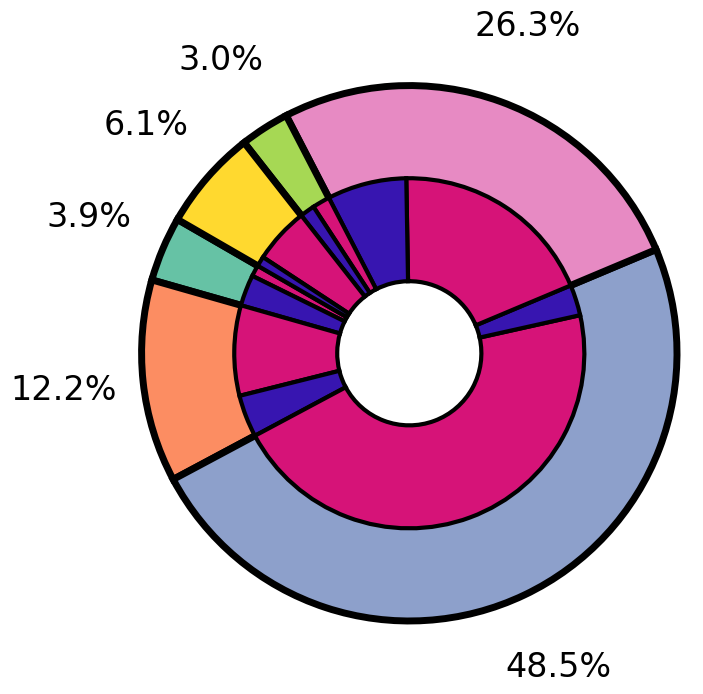

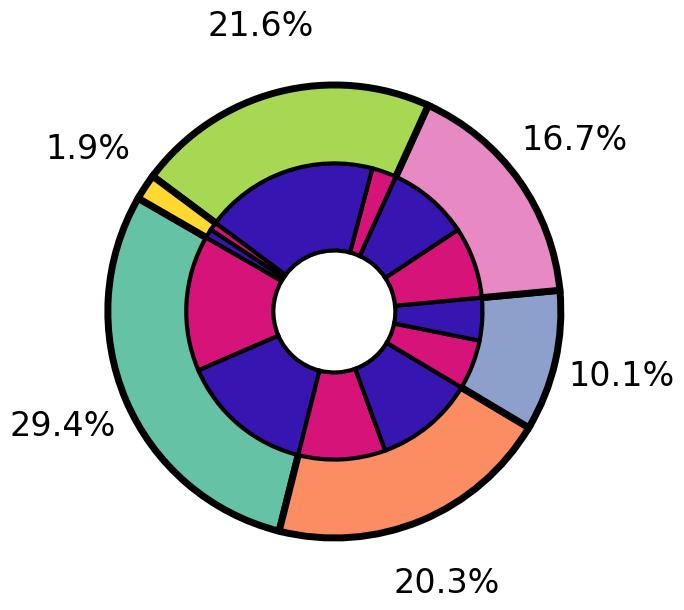

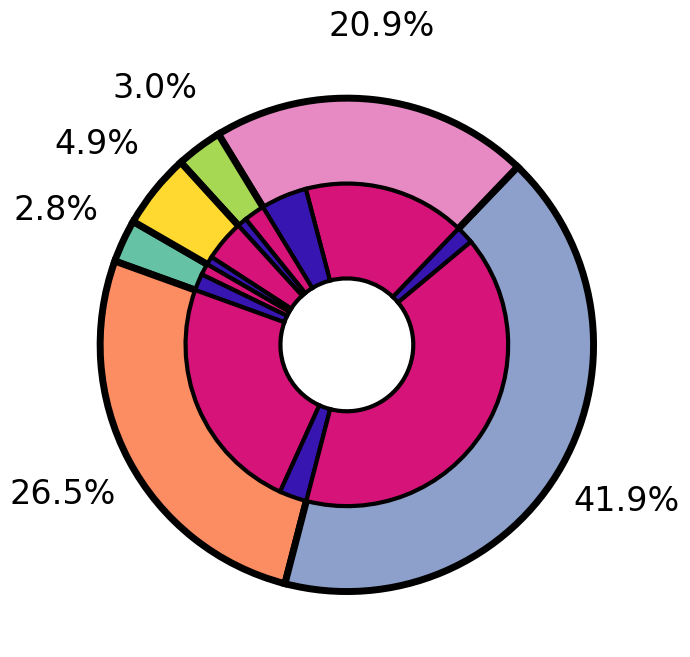

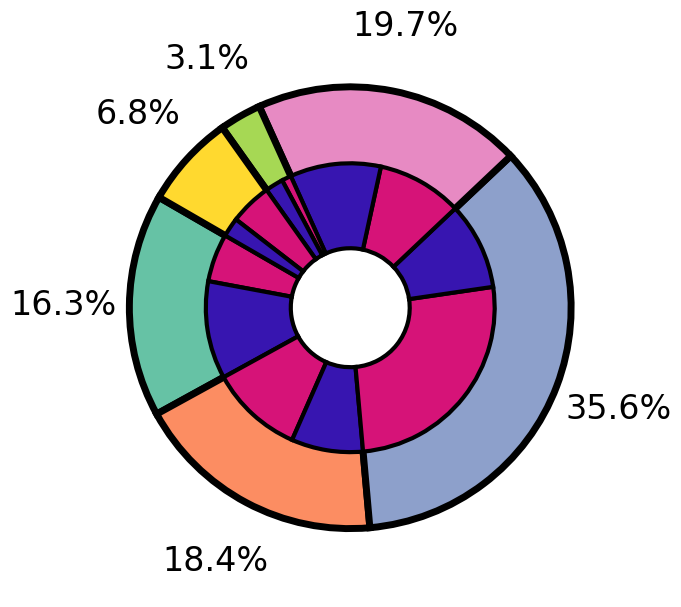

In [29]:
for domain in domains:
    sizes = process_comp(temp, domain)
    fig = plot_my_pie(sizes, colors)

    target = figures.joinpath("compartments_coverage")
    target.mkdir(exist_ok=True)
    fig.savefig(target.joinpath(f"{domain}_pieplot_genic_intergenic.png"), bbox_inches='tight')
    
    fig.savefig(".png", bbox_inches='tight')
    plt.show();  

# Genomic Subcompartment Overlap

In [32]:
len(set(df_merged_grouped[df_merged_grouped['total_tandem'].isna()]['#assembly_accession']))

19145

In [33]:
df_merged_grouped.loc[:, "hit_percentage"] = df_merged_grouped["hits"].div(df_merged_grouped["total_tandem"])

In [34]:
temp = df_merged_grouped[(df_merged_grouped["sru"] == "all") & (df_merged_grouped["mergedCompartment"] == "genome") ]
temp['total_tandem'] = temp['total_tandem'].fillna(0.0)
temp = temp.assign(total_tandem=lambda ds: ds['total_tandem'].astype(int))
temp

,#assembly_accession,mergedCompartment,sru,basePairsCovering,compartmentSize,genome_size,gc_percent,hits,total_gene_count,superkingdom,kingdom,phylum,density,tandem_counts,total_tandem,hit_percentage
39,GCA_000007325.1,genome,all,2275,2174500,2174500,27.0,189,2067,Bacteria,Eubacteria,Fusobacteriota,1046.217521,189,189,1.0
79,GCA_000007385.1,genome,all,10006,4941439,4941439,63.5,684,4697,Bacteria,Eubacteria,Pseudomonadota,2024.916224,684,684,1.0
119,GCA_000008005.1,genome,all,3425,5432652,5432652,35.5,270,6014,Bacteria,Eubacteria,Bacillota,630.447155,270,270,1.0
159,GCA_000008085.1,genome,all,371,490885,490885,31.5,32,553,Archaea,Archaeabacteria,Nanoarchaeota,755.777830,32,32,1.0
199,GCA_000008885.1,genome,all,3783,703004,703004,22.5,335,645,Bacteria,Eubacteria,Pseudomonadota,5381.192710,335,335,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3959309,GCF_963920465.1,genome,all,4421,2816659,2816659,63.0,346,3051,Bacteria,Eubacteria,Cyanobacteriota,1569.590071,346,346,1.0
3959349,GCF_963920475.1,genome,all,6746,3210252,3210252,66.0,532,3318,Bacteria,Eubacteria,Cyanobacteriota,2101.392663,532,532,1.0
3959389,GCF_963920485.1,genome,all,5151,2656680,2656680,62.5,401,2846,Bacteria,Eubacteria,Cyanobacteriota,1938.886129,401,401,1.0
3959429,GCF_963920495.1,genome,all,7681,3384084,3384084,65.5,588,3384,Bacteria,Eubacteria,Cyanobacteriota,2269.742713,588,588,1.0


In [35]:
compartment_hits = df_merged_grouped.groupby(['superkingdom', 'mergedCompartment', 'sru'], as_index=False)\
                .agg({
                    "density": "mean",
                    "gc_percent": "mean",
                    })
compartment_hits

,superkingdom,mergedCompartment,sru,density,gc_percent
0,Archaea,CDS,1,8.492435,49.975232
1,Archaea,CDS,2,79.741670,49.975232
2,Archaea,CDS,3,432.558847,49.975232
3,Archaea,CDS,4,192.951729,49.975232
4,Archaea,CDS,5,23.515151,49.975232
...,...,...,...,...,...
155,Viruses,genome,6,156.568666,45.673968
156,Viruses,genome,7,35.645044,45.673968
157,Viruses,genome,8,10.534598,45.673968
158,Viruses,genome,9,74.132454,45.673968


In [36]:
domain_colors

{'Viruses': '#6bb5c7',
 'Eukaryota': '#ffb2b2',
 'Archaea': '#7b7bed',
 'Bacteria': '#a3c4a3'}

In [37]:
from colour import Color

def construct_color_palette():
    until = {"Archaea": "#2D2D54",
         "Eukaryota": "#A27171",
         "Bacteria": "#404B40",
         "Viruses": "#304F57"
        }
    sru_colors = {}
    for domain in domain_colors:
        c = Color(domain_colors[domain])
        colors = list(map(str, c.range_to(Color(until[domain]), 10)))
        sru_colors.update({domain: {str(i+1): colors[i] for i in range(0, 10)}})
    return sru_colors

In [38]:
sru_colors = construct_color_palette()

In [41]:
# # Data to plot
# labels = [1, 2, 3, 4, 5, 6]
# sizes =  [5609, 17518, 69516, 37634, 4265, 8719]
# hits = [1490, 11898, 65411, 27105, 2313, 7402]
# total =  146033

# labels_compartment = ['Non Coding', 'Coding', 'Intergenic'] * len(labels)
# sizes_compartments = []
# for s, h in zip(sizes, hits):
#     sizes_compartments.extend([h, s-h])
    
# # sizes_gender = [315,189,125,212,270,145,190,90]
# colors_gender = ['#3715b0', '#a1679d', '#84328f'] * len(labels)
 
# # Plot
# colors = list(sru_colors.values())
# # explode = (0, 0, 0, 0, 0, 0, 0.2, 0.2, 0.2)
# # startangle=270
# patches, texts, autotexts = plt.pie(sizes, 
#                                     labels=[''] * len(sizes), 
#                                     colors=colors, 
#                                     counterclock=True, 
#                         textprops={'fontsize': 14}, 
#                         autopct='%1.1f%%', 
#                         radius=1.2,
#         startangle=startangle, 
#         pctdistance=1.2,
#         labeldistance=1.4,
#         shadow=False, 
#         wedgeprops=dict(width=0.5, edgecolor='black', linewidth=5.0), 
#         frame=True)
# plt.pie(sizes_compartments, colors=colors_gender, radius=0.85, startangle=startangle, wedgeprops=dict(width=0.5, edgecolor='black', linewidth=3.0), )
# centre_circle = plt.Circle((0,0), 0.2, color='black', fc='white',linewidth=0)
# fig = plt.gcf()
# fig.gca().add_artist(centre_circle)
 
# plt.axis('equal')
# plt.tight_layout()
# plt.show()

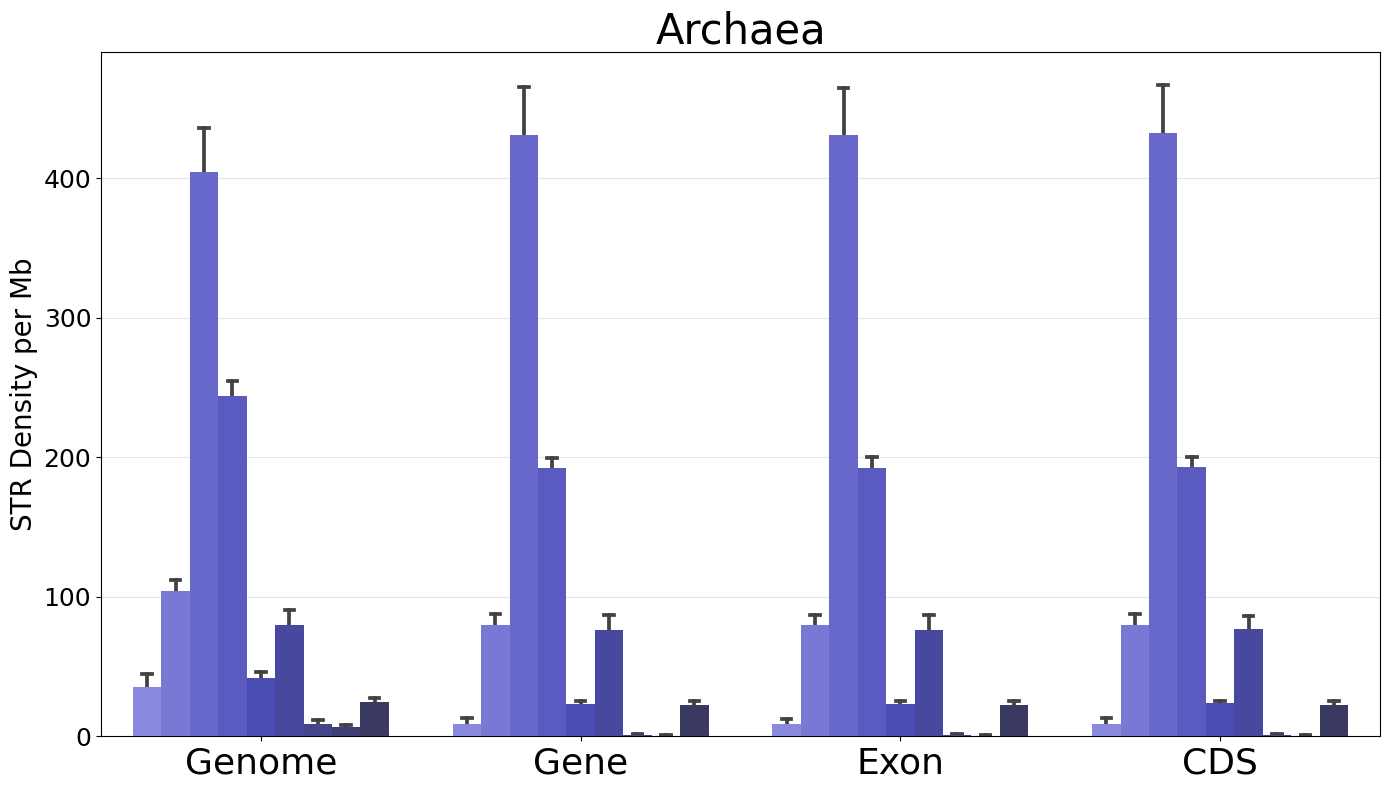

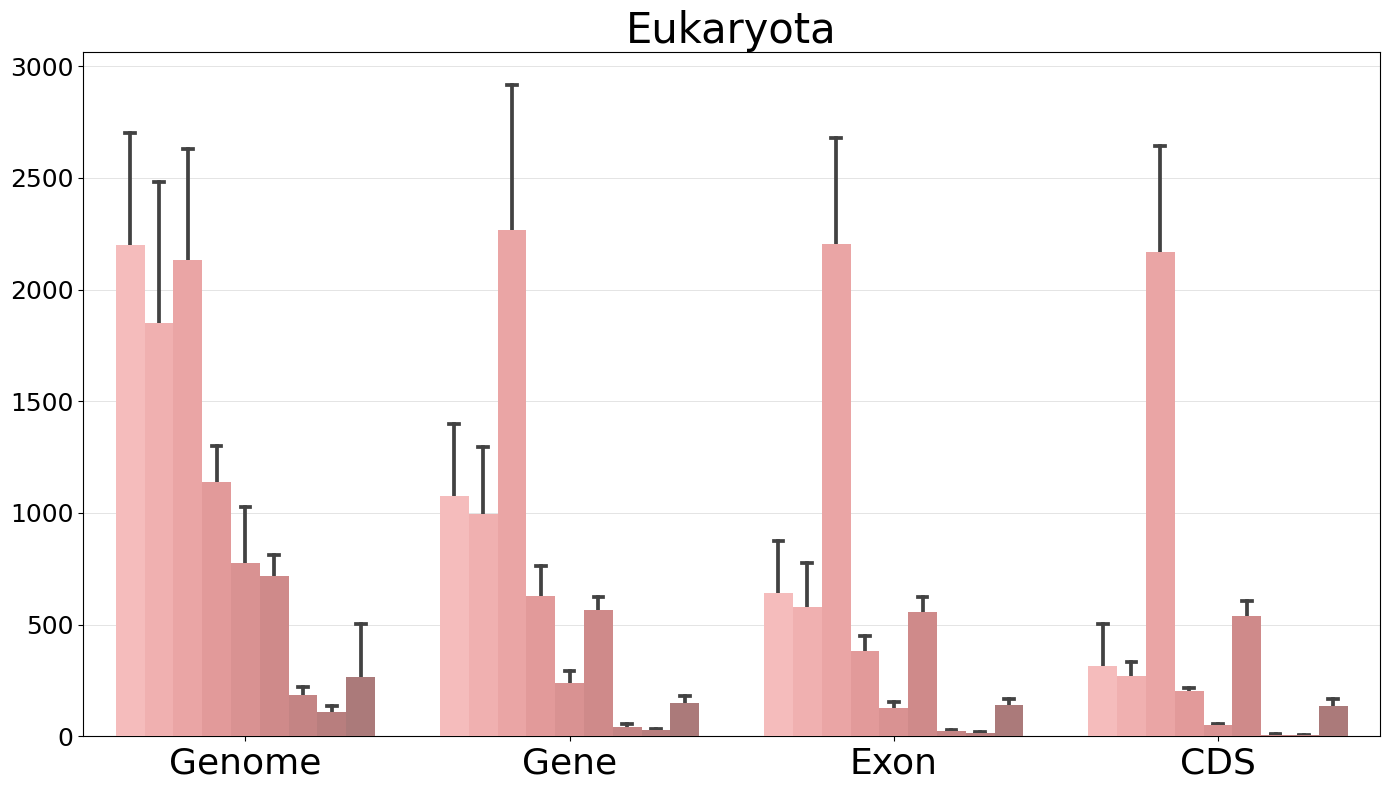

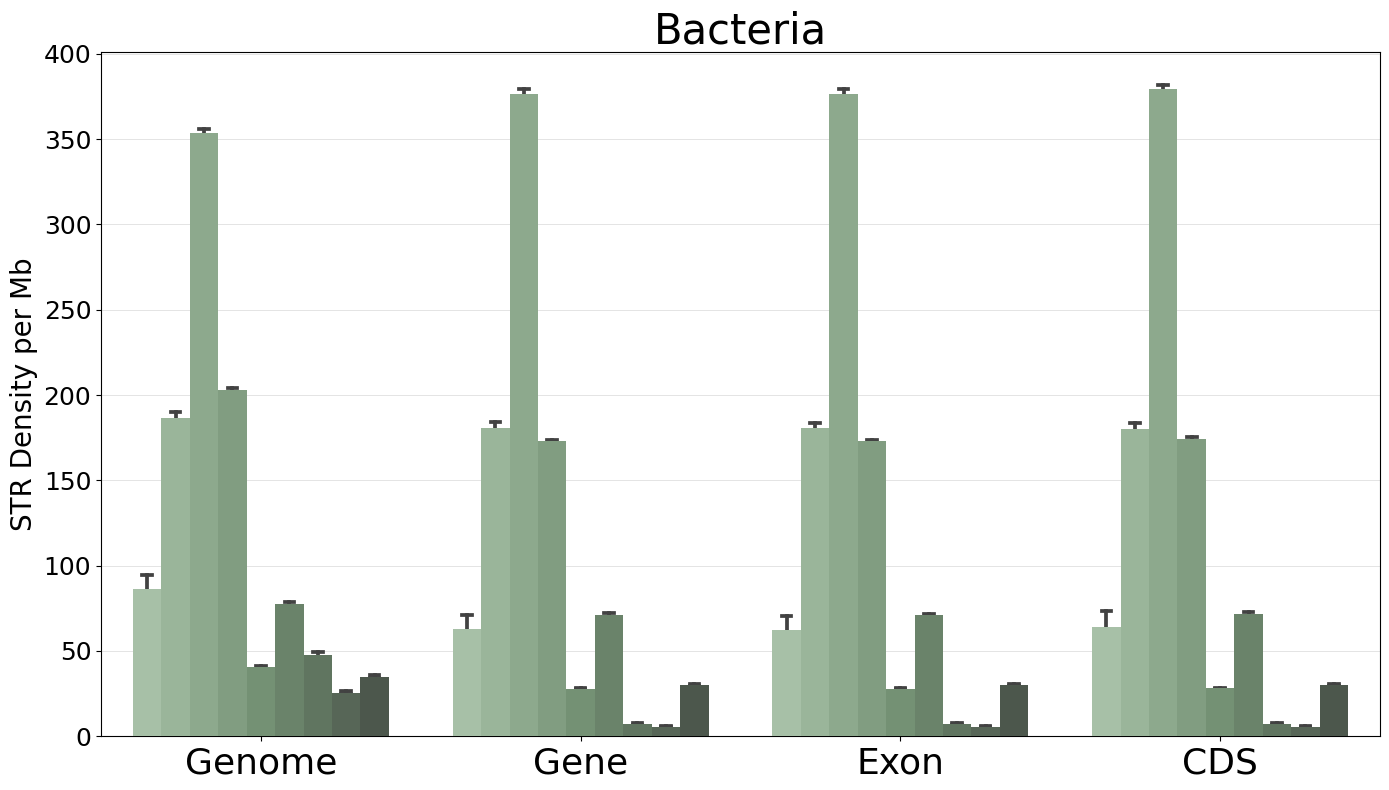

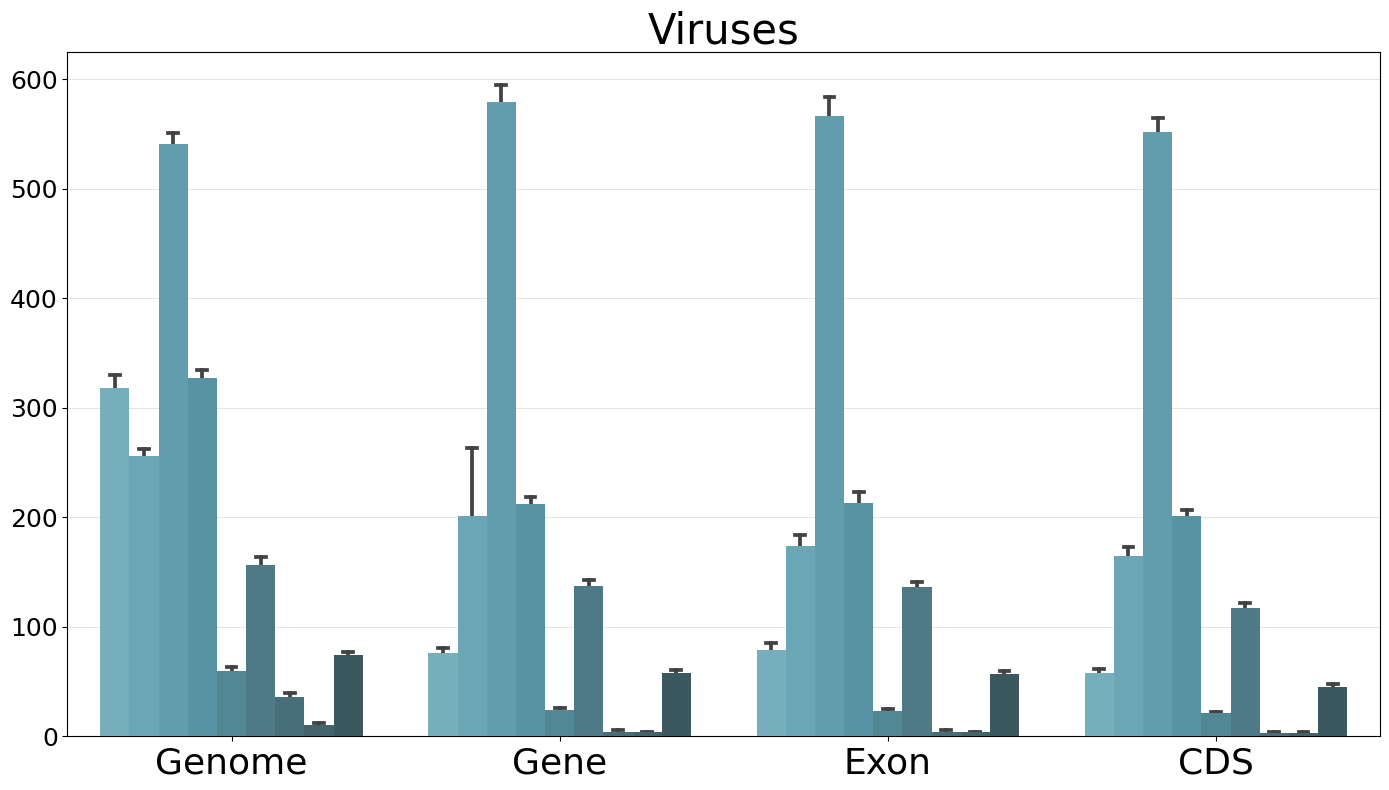

In [44]:
import math
from matplotlib.colors import TwoSlopeNorm

for domain in domains:
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 8))
    ax.grid(lw=0.4, alpha=0.6, zorder=0)
    red_green_pal = sns.diverging_palette(0, 150, n=256, as_cmap=True)
    temp = df_merged_grouped.query(f"superkingdom == '{domain}' & sru != 'all'")
    temp['mergedCompartment'] = temp['mergedCompartment'].apply(lambda x: x.capitalize() if x != 'CDS' else x)
    
    sns.barplot(data=temp, 
                    x="mergedCompartment", 
                    y="density", 
                    # dodge=False,
                    # yerr=temp['std_coverage'],
                    order=["Genome", "Gene", "Exon", "CDS"],
                    palette=sru_colors[domain],
                    hue="sru", 
                    zorder=3,
                capsize=.03,
                ax=ax
               )
    
    # ax.set_xticklabels(list(map(str, range(1, 10, 1))), minor=True)
    ax.set_title(domain)
    ax.title.set_size(30)
    ax.legend(handles=[], title="", loc=0, frameon=False)

    if domain == "Bacteria" or domain == "Viruses":
        ax.set_xlabel("Genomic Compartment")
    else:
        ax.set_xlabel("")
        
    if domain == "Archaea" or domain == "Bacteria":
        ax.set_ylabel("STR Density per Mb")
    else:
        ax.set_ylabel("")

    ax.xaxis.label.set_size(18)
    ax.yaxis.label.set_size(20)
    ax.set_xlabel("")
    ax.tick_params(axis="both", which="major", labelsize=18)
    ax.tick_params(axis="x", which="major", labelsize=26)
    
    target = figures.joinpath(f"compartments_coverage")
    target.mkdir(exist_ok=True)
    fig.savefig(target.joinpath(f"{domain}_average_compartment_density.png"), bbox_inches='tight')
    plt.tight_layout()
    plt.show()

# Genomic Subcompartment vs. Phylum

In [47]:
df_merged_grouped

,#assembly_accession,mergedCompartment,sru,basePairsCovering,compartmentSize,genome_size,gc_percent,hits,total_gene_count,superkingdom,kingdom,phylum,density,tandem_counts,total_tandem,hit_percentage
0,GCA_000007325.1,CDS,1,32,1932314,2174500,27.0,3,2067,Bacteria,Eubacteria,Fusobacteriota,16.560455,13,189.0,0.015873
1,GCA_000007325.1,CDS,2,296,1932314,2174500,27.0,29,2067,Bacteria,Eubacteria,Fusobacteriota,153.184213,45,189.0,0.153439
2,GCA_000007325.1,CDS,3,687,1932314,2174500,27.0,56,2067,Bacteria,Eubacteria,Fusobacteriota,355.532279,61,189.0,0.296296
3,GCA_000007325.1,CDS,4,461,1932314,2174500,27.0,40,2067,Bacteria,Eubacteria,Fusobacteriota,238.574062,50,189.0,0.211640
4,GCA_000007325.1,CDS,5,134,1932314,2174500,27.0,9,2067,Bacteria,Eubacteria,Fusobacteriota,69.346907,13,189.0,0.047619
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3959465,GCF_963920505.1,genome,6,492,3085273,3085273,66.0,25,3279,Bacteria,Eubacteria,Cyanobacteriota,159.467250,25,516.0,0.048450
3959466,GCF_963920505.1,genome,7,0,3085273,3085273,66.0,0,3279,Bacteria,Eubacteria,Cyanobacteriota,0.000000,0,516.0,0.000000
3959467,GCF_963920505.1,genome,8,0,3085273,3085273,66.0,0,3279,Bacteria,Eubacteria,Cyanobacteriota,0.000000,0,516.0,0.000000
3959468,GCF_963920505.1,genome,9,0,3085273,3085273,66.0,0,3279,Bacteria,Eubacteria,Cyanobacteriota,0.000000,0,516.0,0.000000


In [48]:
total_phylums = df_merged_grouped['phylum'].nunique()
for compartment in ["CDS", "exon", "gene",]:
    temp = df_merged_grouped.query(f"compartment == '{compartment}' & sru == 'all'").dropna(subset=['phylum'])
    temp['kingdom'] = temp['kingdom'].apply(lambda x: 'Viruses' if x not in {'Fungi', 'Plantae', 'Protista', 'Eubacteria', 'Archaeabacteria', 'Animalia'} else x)
    
    grouped_per_phylum = temp.groupby("phylum", as_index=False).agg(mean_coverage=("coverage", "mean"))\
                                                             .sort_values(by=['mean_coverage'], ascending=False)
    top_phyla = grouped_per_phylum.iloc[:total_phylums//2]
    bottom_phyla = grouped_per_phylum.iloc[total_phylums//2:]
    max_coverage = top_phyla['mean_coverage'].max()

    temp_top = temp.merge(top_phyla, on="phylum").drop(columns=['compartment', 'sru'])\
                                                    .sort_values(by=['mean_coverage'], ascending=False)
       
    temp_bottom = temp.merge(bottom_phyla, on="phylum").drop(columns=['compartment', 'sru'])\
                                                      .sort_values(by=['mean_coverage'], ascending=False)
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(17, 20))
    ay1 = sns.barplot(x='coverage', 
                      y='phylum', 
                      orient="h", 
                     # width=0.6, 
                     # errorbar=('ci', .95), 
                     data=temp_top, 
                     hue="kingdom", 
                     dodge=False,
                     palette=kingdom_color_palette,
                #saturation=0.5,
                     ax=ax[0],
                     alpha=1.0)
    ay2 = sns.barplot(x='coverage', y='phylum', orient="h", 
                     # width=0.6, 
                     # errorbar=('ci', .95), 
                     dodge=False,
                     data=temp_bottom, 
                     hue="kingdom",
                     palette=kingdom_color_palette,
                     ax=ax[1],
                     alpha=1.0)
    for i in range(2):
            
        ax[i].xaxis.grid(True, linewidth=0.4, alpha=0.6, zorder=0)
        if i == 0:
            ax[i].set_ylabel("Phylum")
            ax[i].yaxis.label.set_size(18)
            ax[i].legend(handles=[], frameon=False)
        else:
            ax[i].set_xlim(xmax=max_coverage)
            ax[i].set_ylabel("")
            # ax[i].legend(handles=[mpatches.Patch(color=color, label=kingdom.capitalize()) for kingdom, color in kingdom_color_palette.items()],
            #                    bbox_to_anchor=(0.6, 0.25), frameon=True, 
            #                     fancybox=True, 
            #                     shadow=False, 
            #                     title="Kingdom", 
            #                     title_fontsize='x-small', 
            #                     prop={"size": 5})
        ax[i].legend(handles=[], frameon=False, title="")
        
            
        # ax[i].set_xlim(0, 15.0)
        ax[i].set_xlabel("Average Microsatellite Density per Kb")
        
        ax[i].xaxis.label.set_size(18)
        ax[i].tick_params(axis="both",  which="major", labelsize=16)
        ax[i].set_axisbelow(True)
        ax[i].margins(y=0.01)
        
    
    # fig.set_size_inches(20, 10)
    print(compartment)
    target = figures.joinpath(f"compartments_coverage")
    target.mkdir(exist_ok=True)
    plt.tight_layout()
    fig.savefig(target.joinpath(f"microsatellite_coverage_compartment_barplot_phylums_{compartment}.png"), bbox_inches='tight')
    plt.show();

UndefinedVariableError: name 'compartment' is not defined

In [ ]:
total_phylums = df['phylum'].nunique()
for compartment in ["CDS", "exon", "gene"]:
    temp = df_merged_grouped.query(f"compartment == '{compartment}' & sru == 'all'").dropna(subset=['phylum'])
    temp['kingdom'] = temp['kingdom'].apply(lambda x: 'Viruses' if x not in {'Fungi', 'Plantae', 'Protista', 'Eubacteria', 'Archaeabacteria', 'Animalia'} else x)
    
    grouped_per_phylum = temp.groupby("phylum", as_index=False).agg(mean_coverage=("coverage", "mean"))\
                                                             .sort_values(by=['mean_coverage'], ascending=False)
    top_phyla = grouped_per_phylum.iloc[:total_phylums//2]
    bottom_phyla = grouped_per_phylum.iloc[total_phylums//2:]
    max_coverage = top_phyla['mean_coverage'].max()

    temp_top = temp.merge(top_phyla, on="phylum").drop(columns=['compartment', 'sru'])\
                                                    .sort_values(by=['mean_coverage'], ascending=False)
       
    temp_bottom = temp.merge(bottom_phyla, on="phylum").drop(columns=['compartment', 'sru'])\
                                                      .sort_values(by=['mean_coverage'], ascending=False)
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(17, 20))
    ay1 = sns.barplot(x='coverage', 
                      y='phylum', 
                      orient="h", 
                     # width=0.6, 
                     # errorbar=('ci', .95), 
                     data=temp_top, 
                     hue="kingdom", 
                     dodge=False,
                     palette=kingdom_color_palette,
                #saturation=0.5,
                     ax=ax[0],
                     alpha=1.0)
    ay2 = sns.barplot(x='coverage', y='phylum', orient="h", 
                     # width=0.6, 
                     # errorbar=('ci', .95), 
                     dodge=False,
                     data=temp_bottom, 
                     hue="kingdom",
                     palette=kingdom_color_palette,
                     ax=ax[1],
                     alpha=1.0)
    for i in range(2):
            
        ax[i].xaxis.grid(True, linewidth=0.4, alpha=0.6, zorder=0)
        if i == 0:
            ax[i].set_ylabel("Phylum")
            ax[i].yaxis.label.set_size(18)
            ax[i].legend(handles=[], frameon=False)
        else:
            ax[i].set_xlim(xmax=max_coverage)
            ax[i].set_ylabel("")
            # ax[i].legend(handles=[mpatches.Patch(color=color, label=kingdom.capitalize()) for kingdom, color in kingdom_color_palette.items()],
            #                    bbox_to_anchor=(0.6, 0.25), frameon=True, 
            #                     fancybox=True, 
            #                     shadow=False, 
            #                     title="Kingdom", 
            #                     title_fontsize='x-small', 
            #                     prop={"size": 5})
        ax[i].legend(handles=[], frameon=False, title="")
        
            
        # ax[i].set_xlim(0, 15.0)
        ax[i].set_xlabel("Average Microsatellite Density per Kb")
        
        ax[i].xaxis.label.set_size(18)
        ax[i].tick_params(axis="both",  which="major", labelsize=16)
        ax[i].set_axisbelow(True)
        ax[i].margins(y=0.01)
        
    
    # fig.set_size_inches(20, 10)
    print(compartment)
    target = figures.joinpath(f"compartments_coverage")
    target.mkdir(exist_ok=True)
    
    plt.tight_layout()
    fig.savefig(target.joinpath(f"microsatellite_coverage_compartment_barplot_phylums_{compartment}.png"), bbox_inches='tight')
    plt.show();

In [ ]:
total_phylums = df['phylum'].nunique()
for compartment in ["CDS", "exon", "gene"]:
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(17, 20))
    temp = df.query(f"compartment == '{compartment}' & sru == 'all'").dropna(subset=['phylum'])
    temp['kingdom'] = temp['kingdom'].apply(lambda x: 'Viruses' if x not in {'Fungi', 'Plantae', 'Protista', 'Eubacteria', 'Archaeabacteria', 'Animalia'} else x)
    
    grouped_per_phylum = temp.groupby("phylum", as_index=False).agg(median_coverage=("coverage", "median"))\
                                                             .sort_values(by=['median_coverage'], ascending=False)
    top_phyla = grouped_per_phylum.iloc[:total_phylums//2]
    bottom_phyla = grouped_per_phylum.iloc[total_phylums//2:]
    
    temp_top = temp.merge(top_phyla, on="phylum").drop(columns=['compartment', 'sru'])\
                                                      .sort_values(by=['median_coverage'], ascending=False)
       
    temp_bottom = temp.merge(bottom_phyla, on="phylum").drop(columns=['compartment', 'sru'])\
                                                      .sort_values(by=['median_coverage'], ascending=False)
    sns.stripplot(data=temp_top,
                        y="phylum",
                        x="coverage",
                        hue="kingdom",
                          jitter=True, 
                          s=6,
                          marker='D',
                        palette=kingdom_color_palette,
                    dodge=0.0,
                      alpha=0.6,
                ax=ax[0],
                zorder=3,
               )
    sns.stripplot(data=temp_bottom,
                    y="phylum",
                    x="coverage",
                    hue="kingdom",
                      jitter=True, 
                      s=6,
                      marker='D',
                palette=kingdom_color_palette,
                dodge=0.0,
                  alpha=0.6,
            ax=ax[1],
            zorder=3,
           )
    for i in range(2):
        ax[i].grid(lw=0.4, alpha=0.7, zorder=0)
        ax[i].tick_params(axis="both", which="major", labelsize=16)
        ax[i].legend(loc=0, handles=[], title="", frameon=False)
        if i == 0:
            ax[i].set_ylabel("Phylum")
            ax[i].yaxis.label.set_size(18)
        else:
            ax[i].set_ylabel("")

        ax[i].set_xlabel(f"Average Microsatellite Density per Kb")
        ax[i].xaxis.label.set_size(18)
            
    print(compartment)
    target = figures.joinpath(f"compartments_coverage")
    target.mkdir(exist_ok=True)
    plt.tight_layout()
    fig.savefig(target.joinpath(f"tr_coverage_compartment_stripplot_{compartment}.png"), bbox_inches='tight')
    # plt.suptitle(compartment, fontsize=22)
    plt.show()


In [549]:
df_merged_grouped.isna().sum()

#assembly_accession         0
mergedCompartment           0
sru                         0
basePairsCovering           0
compartmentSize             0
genome_size                 0
gc_percent                  0
hits                        0
total_gene_count            0
superkingdom                0
kingdom                 62070
phylum                 294070
density                     0
tandem_counts               0
total_tandem           566030
dtype: int64

In [566]:
df_merged_grouped[df_merged_grouped['phylum'].isna()]

,#assembly_accession,mergedCompartment,sru,basePairsCovering,compartmentSize,genome_size,gc_percent,hits,total_gene_count,superkingdom,kingdom,phylum,density,tandem_counts,total_tandem
8140,GCA_000529295.1,CDS,1,2,121583,142709,43.5,1,137,Viruses,Unclassified Viruses,None,16.449668,4,106.0
8141,GCA_000529295.1,CDS,2,0,121583,142709,43.5,0,137,Viruses,Unclassified Viruses,None,0.000000,8,106.0
8142,GCA_000529295.1,CDS,3,1275,121583,142709,43.5,81,137,Viruses,Unclassified Viruses,None,10486.663432,89,106.0
8143,GCA_000529295.1,CDS,4,12,121583,142709,43.5,1,137,Viruses,Unclassified Viruses,None,98.698009,2,106.0
8144,GCA_000529295.1,CDS,5,0,121583,142709,43.5,0,137,Viruses,Unclassified Viruses,None,0.000000,0,106.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3958905,GCF_963693035.1,genome,6,606,4178193,4178193,68.0,29,4114,Bacteria,Eubacteria,None,145.038776,29,952.0
3958906,GCF_963693035.1,genome,7,77,4178193,4178193,68.0,3,4114,Bacteria,Eubacteria,None,18.429019,3,952.0
3958907,GCF_963693035.1,genome,8,56,4178193,4178193,68.0,1,4114,Bacteria,Eubacteria,None,13.402923,1,952.0
3958908,GCF_963693035.1,genome,9,0,4178193,4178193,68.0,0,4114,Bacteria,Eubacteria,None,0.000000,0,952.0


In [167]:
import math

phylum_df = df_merged_grouped\
            .dropna(subset=['phylum'])\
            .groupby(["mergedCompartment", "phylum"], as_index=False)\
            .agg({
                  "density": "mean", 
                  "superkingdom": "first", 
                  "kingdom": "first"
                 })
phylum_df['density'] = phylum_df['density'].apply(lambda y: math.log(y+1, 10))
phylum_df

,mergedCompartment,phylum,density,superkingdom,kingdom
0,CDS,Abditibacteriota,2.034066,Bacteria,Eubacteria
1,CDS,Acidobacteriota,2.279866,Bacteria,Eubacteria
2,CDS,Actinomycetota,2.411705,Bacteria,Eubacteria
3,CDS,Apicomplexa,3.261230,Eukaryota,Protista
4,CDS,Aquificota,2.155917,Bacteria,Eubacteria
...,...,...,...,...,...
455,genome,Uroviricota,2.302712,Viruses,Heunggongvirae
456,genome,Verrucomicrobiota,2.266755,Bacteria,Eubacteria
457,genome,Vulcanimicrobiota,2.935723,Bacteria,Eubacteria
458,genome,candidate division NC10,2.235769,Bacteria,Eubacteria


In [168]:
superkingdom_col = phylum_df['superkingdom'].map(domain_colors)
kingdom_col = phylum_df['kingdom'].map(kingdom_color_palette)

In [169]:
phylum_df['kingdom'] = phylum_df['kingdom'].apply(lambda x: 'Viruses' if x not in {'Fungi', 'Plantae', 'Eubacteria', 'Archaeabacteria', 'Animalia', 'Protista'} else x)
superkingdom_col = phylum_df['superkingdom'].map(domain_colors)
kingdom_col = phylum_df['kingdom'].map(kingdom_color_palette)

In [170]:
pivot_phylum = phylum_df.pivot(index='phylum', columns='mergedCompartment', values='density')[["genome", "gene", "exon", "CDS"]]\
                    .rename(columns={"genome": "Genome", "gene": "Gene", "exon": "Exon"})
pivot_phylum

mergedCompartment,Genome,Gene,Exon,CDS
phylum,,,,
Abditibacteriota,2.017833,2.033105,2.033105,2.034066
Acidobacteriota,2.358055,2.279083,2.279083,2.279866
Actinomycetota,2.440043,2.410292,2.410240,2.411705
Apicomplexa,3.629564,3.430218,3.313759,3.261230
Aquificota,2.176785,2.152366,2.152504,2.155917
...,...,...,...,...
Uroviricota,2.302712,2.250775,2.247712,2.234533
Verrucomicrobiota,2.266755,2.233009,2.233047,2.237045
Vulcanimicrobiota,2.935723,2.952213,2.952213,2.953413


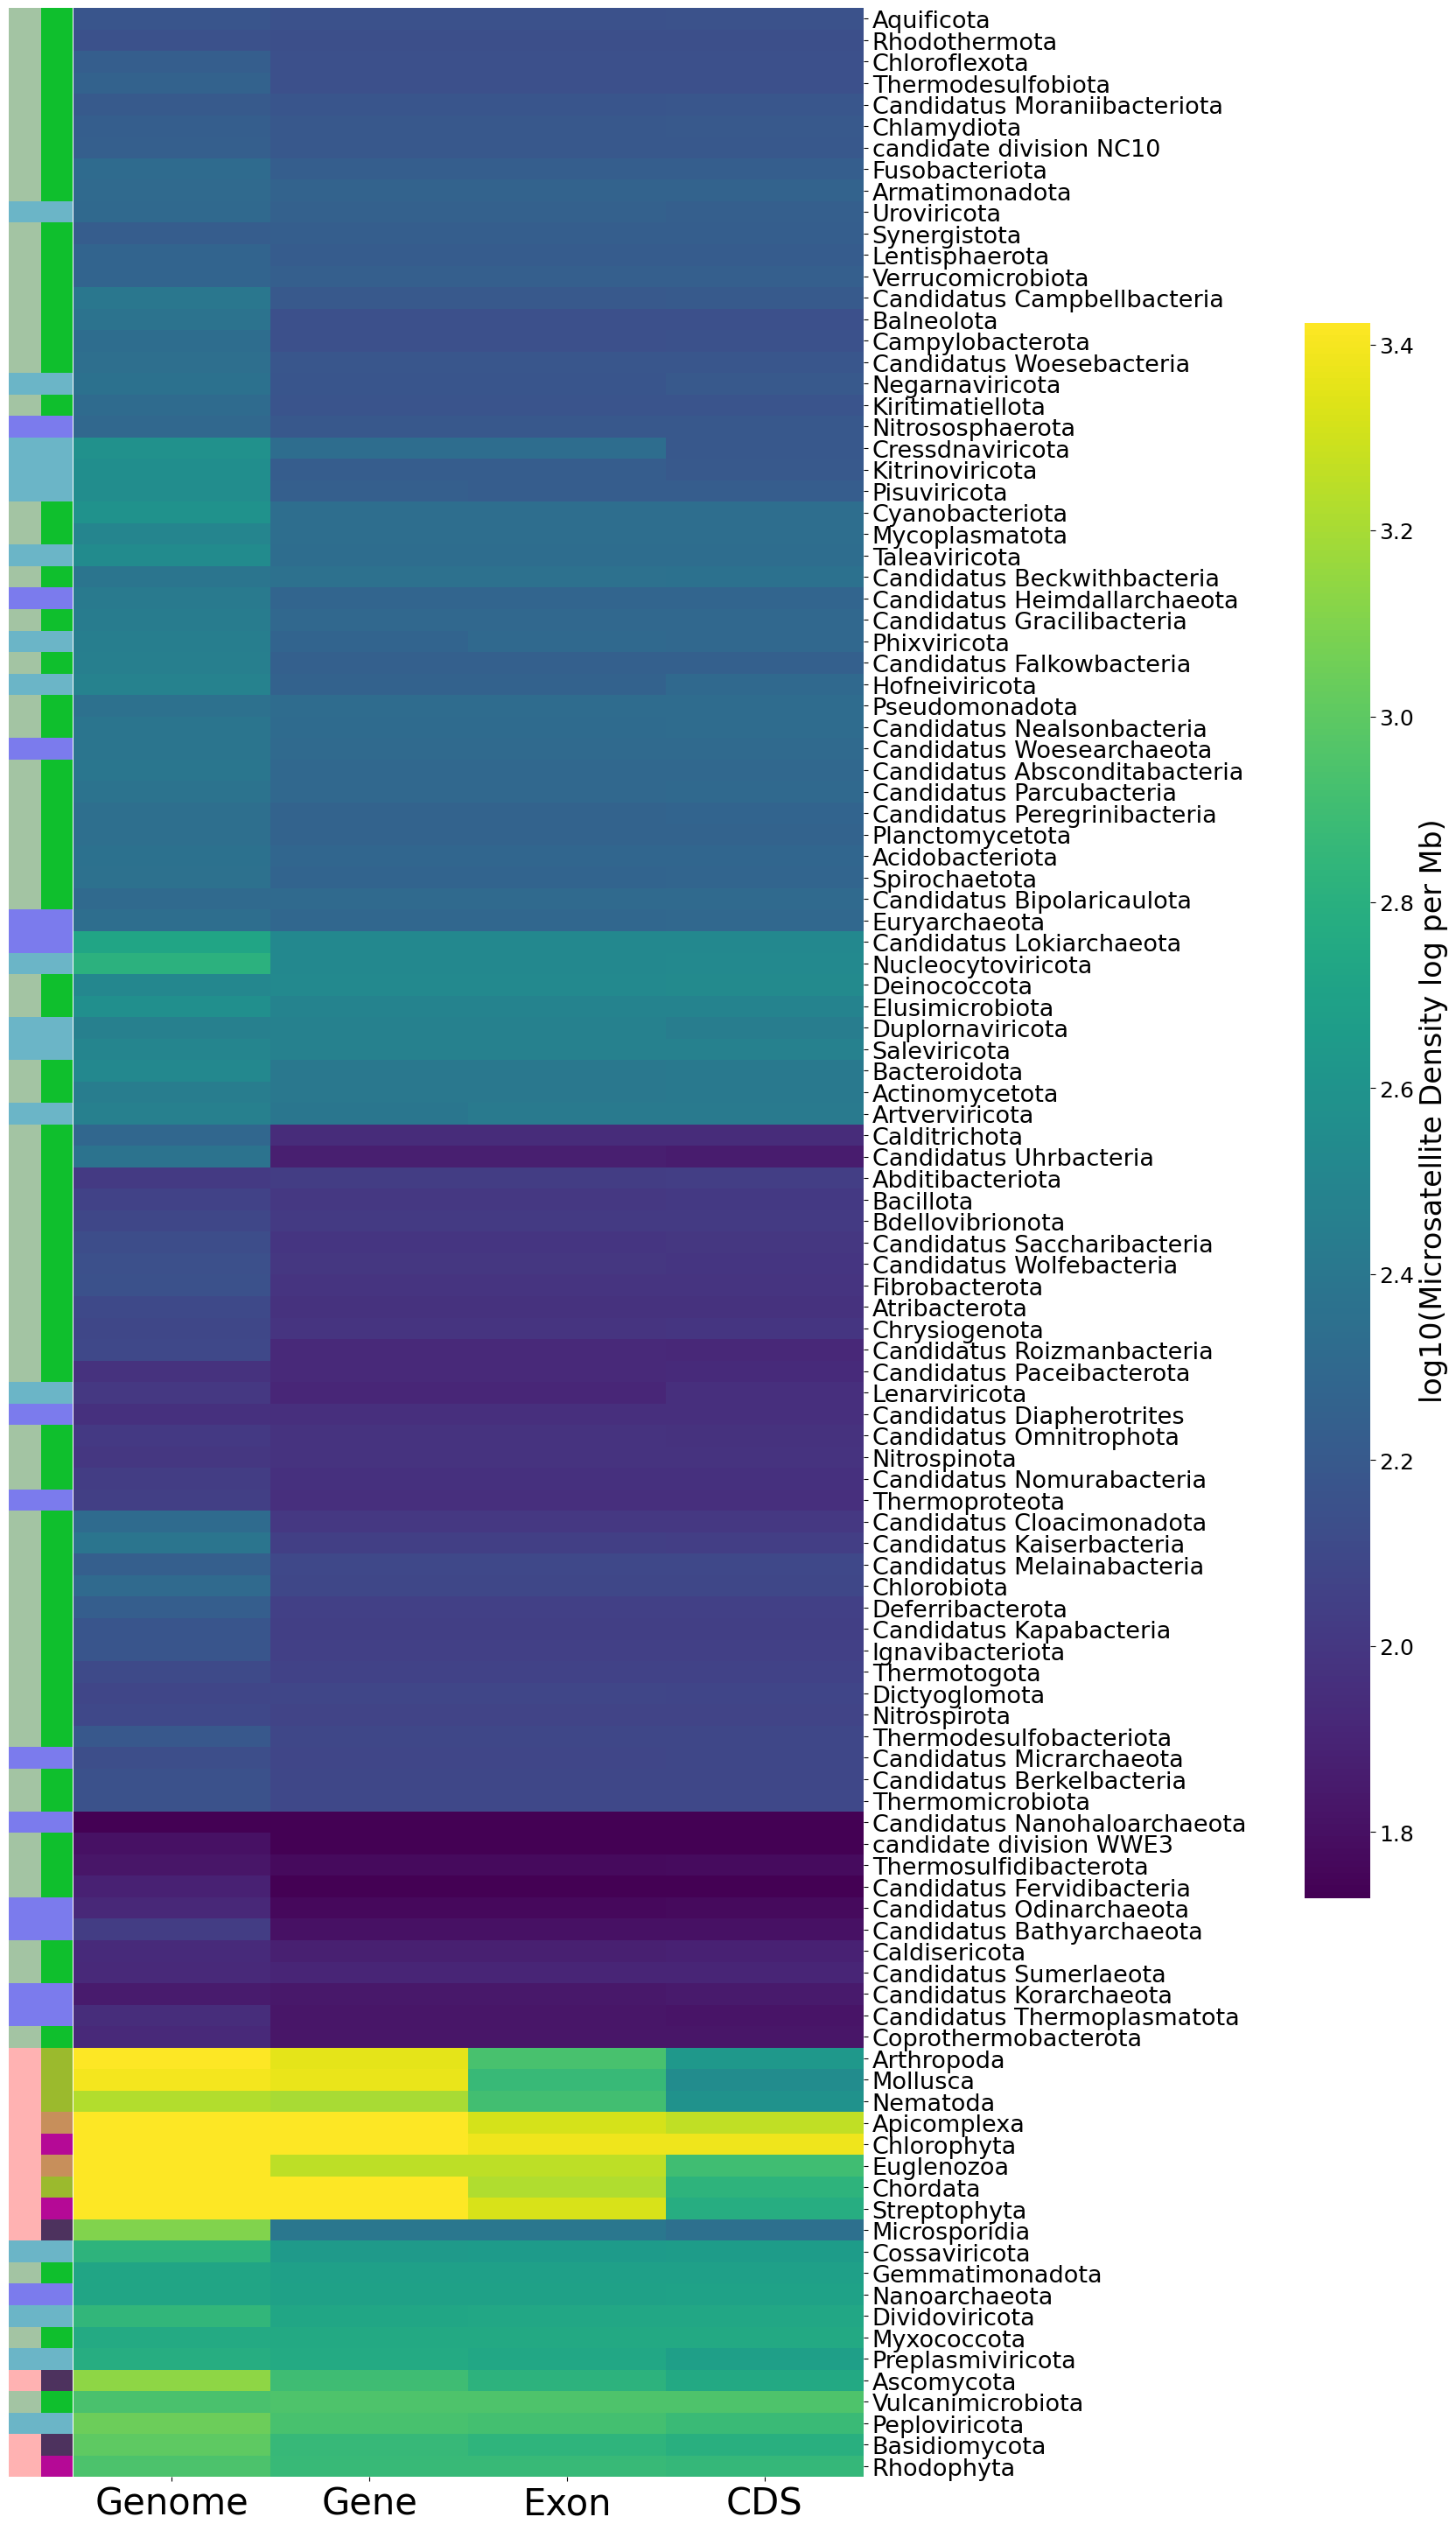

In [172]:
# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
kws = dict(cbar_kws=dict(location="top", shrink=0.2))

figsize=(15, 36)
compartments = ["CDS", "exon", "gene", "genome"]

# .apply(lambda x: math.log(x+1, 10))
cmap = matplotlib.cm.get_cmap('viridis')
cmap.set_bad("#cdd4cf")
mask = np.where(pivot_phylum==-1, True, False)

    
cg = sns.clustermap(
                  pivot_phylum,
                   row_colors=[superkingdom_col, kingdom_col],
                   row_cluster=True, 
                   col_cluster=False,
                   #method="average",
                    # vmax=1.0,
                    cmap=cmap,
                            mask=mask,
                   figsize=figsize,
                   robust=True,
                   yticklabels=True, 
                   xticklabels=True,
                   cbar_kws={"shrink": 0.1, "orientation": "vertical"}
                   )
ax = cg.ax_heatmap


cg.ax_row_dendrogram.set_visible(False)
cg.ax_col_dendrogram.set_visible(False)
ax = cg.ax_heatmap
ax.set_xlabel("")
# ax.yaxis.set_major_locator(plt.MaxNLocator(3))
ax.set_ylabel("")
# ax.set_title("Phylum")
# ax.title.set_size(16)
t = ax.xaxis.get_majorticklocs()
# origin = "TSS" if ts == "start" else "TES"
# ax.set_xticks(range(len(t)), [{
#                                len(t)//2: origin, 
#                                0: -500, 
#                                len(t)//2 + len(t)//4: 250, 
#                                len(t)//4: -250, 
#                                len(t)-1: 500
#                               }.get(i, "") for i in range(len(t))])
ax.xaxis.label.set_size(16)
ax.yaxis.label.set_size(16)
ax.tick_params(axis="both", 
               which="major", 
               labelsize=19.5,
               rotation=0
              )
ax.tick_params(axis="x", 
               which="major", 
               labelsize=30,
               rotation=0
              )

# Customize colorbar properties
x0, _y0, _w, _h = cg.cbar_pos
cg.ax_cbar.set_position([1.16, 0.2, 0.05, 0.5])
# cg.cax.set_position([0.075, 0.2, 0.04, 0.65])  # Adjust the position of the colorbar
cg.ax_cbar.tick_params(axis='both', length=4, labelsize=18)

# Add a label to the colorbar
cg.cax.set_ylabel('log10(Microsatellite Density log per Mb)', size=24) #, labelpad=15, size=12)
for spine in cg.ax_cbar.spines:
    cg.ax_cbar.spines[spine].set_color('black')
    # cg.ax_cbar.spines[spine].set_linewidth(2)

target = figures.joinpath(f"compartments_coverage")
target.mkdir(exist_ok=True)
plt.tight_layout()
fig = plt.gcf()
fig.savefig(target.joinpath(f"clustermap_compartment_transcription_sites_phylum.png"), bbox_inches='tight')
plt.show()

# 